In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
# import sklearn
# print("sklearn version: ", sklearn.__version__)
# assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
print("TF version: ", tf.__version__)
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")    

TF version:  2.4.0
GPU installed:  True
1 Physical GPUs, 1 Logical GPUs


In [292]:
import numpy as np
import pandas as pd
import os
import time
# import scoring as scoring
import pickle
import gzip
from pyarrow import csv
import csv
# train_path = "D:/2022AIComp_data/train.csv"
# test_path = "D:/2022AIComp_data/test.csv"

#---------------------- Load Train,Test DF
train_pd = pd.read_csv("D:/2022AIComp_data/train.csv")
test_pd = pd.read_csv("D:/2022AIComp_data/test.csv")
test_correct = pd.read_csv("D:/2022AIComp_data/test3_aic_best.csv")
print("Train: %s, Test: %s" %(train_pd.shape, test_pd.shape))
train_pd.head()
print(train_pd.iloc[:,0].unique())
# test_pd.head()


def remake_data():
    X = np.array(train_pd.iloc[:,1:])
    y = train_pd.iloc[:,0].replace(['out','in', 'normal', 'other', 'noise'],[0,1,2,3,4])
    # y_train = np.argmax(np.array(pd.get_dummies(train_pd.iloc[:,0])),axis=1)

    submit_test = np.array(test_pd.iloc[:,1:])

    # y_test = np.array(pd.get_dummies(test_pd.iloc[:,0]))
    #data Normalize

    return X,y,submit_test

Train: (33600, 514), Test: (7820, 514)
['out' 'in' 'normal' 'other' 'noise']


In [265]:
import sklearn.model_selection
from sklearn.model_selection import train_test_split


# from sklearn import model_selection
class PreProcessing():
#     def __init__(self,**kwargs):


    def data_shape(self,*data_li,local = None):
        for data in data_li:
            vnames = [name for name in globals() if globals()[name] is data ]
            if len(vnames) != 0:
                print(vnames[0],'.shape : ',data.shape)
            else:
                if local == None: local = locals()
                vnames = [name for name in local if local[name] is data]
                print(vnames[0],'.shape : ',data.shape)
        print('\n')

    
    def data_reshape(self, *args, **kwargs):
        reshaped = []
        print(kwargs['shape'])
        for data in args:
            reshaped.append(data.reshape(kwargs['shape']))
        return reshaped
    
    
    def split(self,X,y):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state = 42, stratify = y)
        return X_train, X_test, y_train, y_test
    
    def transform_label(self,y,label):
        y[y!=label]= 1
        y[y==label]=0
        
        print('0 : ', len(y[y==0]), '1 : ',len(y[y==1]) )
        return y
    
    def transform_train(self,X,y,label):
        X=X[y==label]
        y=y[y==label]
        return X,y
    
    def drop_train(self,X,y,label):
        X=X[y!=label]
        y=y[y!=label]
        return X,y
    
    def make_label_set(self, X,y,label):
        X_sub=[]
        y_sub=[]
        for i in label:
            X_sub.append(X[y==i])
            y_sub.append(y[y==i])
        

        X=np.concatenate(tuple(X_sub),axis = 0)
        y=np.concatenate(tuple(y_sub),axis = 0)
        y=np.array(pd.get_dummies(y))
        
        return X,y
    
    def dummies(self,y):
        y_n = y
        y= np.zeros((len(y),5))
        for i in y:
            y[i,y_n[i]]=1
    
    def idx(self,y):
        return np.argmax(y,axis=1)
    
    
    def make_max(slef, X):
        max_mag = np.max(X,axis = 1)
        print(max_mag)
        print(len(max_mag))

        max_idx =[]
        for i,j in enumerate(max_mag):
            max_idx.append(np.where(X[i]==j)[0][0])
        print(len(max_idx))
        X=np.concatenate((X,max_mag.reshape(-1,1), np.array(max_idx).reshape(-1,1)),axis = 1)

        return X
        
    
    def pipeline(self, **kwargs):
        X=kwargs.get('X')
        y=kwargs.get('y')
        submit=kwargs.get('submit')
        shape = kwargs.get('shape')
#         label = kwargs.get('label')
        
        
#         y = self.dummies(y)
#         self.y_real=y
        print(np.unique(y))
        
#         print('0 : ', len(y[y==0]), '1 : ',len(y[y==1]) )

#         print('y : ',y)
#         X,y=self.make_label_set(X,y,label)

        y=np.array(pd.get_dummies(y))
    
        self.data_shape(X,y,local = locals())
#         print('y :', y)
        if shape is not None:
#             print(shape)
#             print(len(data))
            X,submit = self.data_reshape(X,submit,shape = shape)
#             print(len(res))
            
        X_train,X_test,y_train,y_test = self.split(X,y)
        self.data_shape(X_train,X_test,y_train,y_test,submit,local = locals())
        
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.submit = submit
        
        return X_train,X_test,y_train,y_test,submit

In [250]:
from tensorflow import keras
from tensorflow.keras import backend as K

def focal_loss(y_true, y_pred):
    gamma = 2
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))


In [242]:
from tensorflow import keras
from datetime import datetime
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score

class Train_model(PreProcessing):
    
    def __init__(self,*args,**kwargs):
        self.args = args,
        self.kwargs = kwargs
#         self.model = model
        self.batch_size = self.get('batch_size',64)
        self.epoch = self.get('epoch',100)
        self.class_weight = self.get('class_weight',True)
        self.loss = self.get('loss','categorical_crossentropy')
        self.optimizer  = self.get('optimizer','sgd')
        self.patience = self.get('patience',20)
        
#         self.X_train = X_train
#         self.y_train = y_train
#         self.X_test = X_test
#         self.y_test = y_test
#         self.submit = submit
        
    def get(self, instance_name,default):
        return self.kwargs.get(instance_name,default)
    
    def this_time(self):
        c = datetime.now() ##모델 돌릴 때 시작 시간
        n_time = c.strftime('%Y-%m-%d_%H_%M')
        print(n_time)
        return(n_time)
    
    def model_save_path(self):
        self.n_time = self.this_time()
        MODEL_SAVE_FOLDER_PATH = './model_flow/'  #모델 저장 경로
        if not os.path.exists(MODEL_SAVE_FOLDER_PATH): 
            os.mkdir(MODEL_SAVE_FOLDER_PATH) 
        model_path = MODEL_SAVE_FOLDER_PATH + str(self.n_time)+'.hdf5'
        return model_path
        
    def early_modelcheck(self, model_path):
            es = EarlyStopping(monitor='val_loss', mode='min', 
                       verbose=1, patience=self.patience, restore_best_weights = True)

            mc = ModelCheckpoint(model_path, monitor='val_loss',
                         mode='min', save_best_only=True)
            return es,mc
        
    def calculate_class_weight(self,y_train):
        
        
#         classes_in = np.argmax(y_train,axis =1)
#         print(classes_in)
        class_weights = compute_class_weight(
            class_weight = 'balanced',classes = np.unique(y_train),y = y_train)
        class_weights = dict(enumerate(class_weights))
        return class_weights
    
    #   model,X_train,y_train,X_test,y_test = args
    def compile_fit(self, *args, **kwargs): 
        loss = kwargs.pop('loss',self.loss)
        optimizer = kwargs.pop('optimizer',self.optimizer)
        
        label= self.get('label',None)
        
        model,X_train,y_train,X_test,y_test = args
        
        model_path = self.model_save_path()
        es,mc = self.early_modelcheck(model_path)
        
        
        class_weights = self.calculate_class_weight(y_train = np.argmax(y_train,axis =1))
        
        model.compile(loss=[focal_loss],optimizer = optimizer,metrics=['accuracy'])
        
        history = model.fit(X_train,y_train, epochs = self.epoch,
                     batch_size=self.batch_size, validation_split=0.2, 
                                callbacks=[es,mc],
                               class_weight = class_weights,
                                shuffle=True,
                       ).history
        
        print('\n-----test score : ',model.evaluate(X_test, y_test))
        self.learning_curve(history)
        
        y_pred = self.predict_label(model,X_test,y_test,label)
        
        return model,y_pred
        
    def learning_curve(self,history):
    
        #러닝 커브
        plt.plot(history['accuracy'], label='train_acc')
        plt.plot(history['val_accuracy'], label= 'val_acc')
        plt.plot(history['loss'], label= 'train_loss')
        plt.plot(history['val_loss'], label= 'val_loss')
        plt.title('Learning Curve')
        plt.xlabel('Epoch')
        plt.legend(loc='lower left')
        plt.show()
    
    #
    def predict_label(self,model,X_test,y_test,label=None):
        
        
        self.data_shape(X_test,y_test,local=locals())
        y_pred = np.argmax(model.predict(X_test),axis=1)
        y_test=np.argmax(y_test,axis=1)
        
        #label pred에 숫자 더함
        if label != None:
            y_pred_re = real_pred(y_pred,label)
        else:
            y_pred_re =y_pred
            
        print(y_test.shape,y_pred.shape)
        show_matrix(y_test,y_pred)
        print('\n-----macro f1 score : ',f1_score(y_test, y_pred, average='macro'))
        print('model_name : ', self.n_time)        
        return y_pred_re
    
    def real_pred(y_pred,label):
        for la_be, la_af in enumerate(label):
            y_pred[y_pred==la_be]=la_af
        return y_pred

        
    
    def make_test_csv(self, model,submit_test,model_name,reshape=False):
        sample_pd = pd.read_csv("D:/2022AIComp_data/sample_submission.csv")
        sample_pd.set_index('id',inplace=True)

        if reshape == True:
            submit_te = submit_test.reshape((-1,27,19,1))
        else:
            submit_te=submit_test
        pred = np.argmax(model.predict(submit_te),axis = 1)
        print(pred.shape)
        sub = pd.concat([test_pd.iloc[:,0],
                               pd.DataFrame(pred,columns=['leaktype']).replace([0,1,2,3,4],['out','in', 'normal', 'other', 'noise'])],axis=1)

        sub.set_index('id',inplace=True)
        submit_pd = sub.reindex(sample_pd.index)
        print('제출 할 csv 클래스 별 분포 : ', submit_pd.value_counts())
        plt.hist(np.array(submit_pd))
        plt.show()

        MODEL_SAVE_FOLDER_PATH = './result_csv/' 
        if not os.path.exists(MODEL_SAVE_FOLDER_PATH): 
            os.mkdir(MODEL_SAVE_FOLDER_PATH) 
        submit_pd.to_csv(MODEL_SAVE_FOLDER_PATH + model_name[:-5]+'.csv')
        print(model_name)
        return submit_pd
    
def show_matrix(y_test,y_pred):
        
#         if len(y_pred[0])!=1:
#             y_pred = np.argmax(y_pred,axis =1)
            
#         if len(y_test[0])!=1:
#             y_test = np.argmax(y_test,axis =1)
        
        print('show_matrix : ',y_test.shape, y_pred.shape)
        cf = confusion_matrix(y_test, y_pred)

        per_cf =[]
        for i in cf:
            per_cf.append(i/np.sum(i))
        axes=[]
    #     plt.rc('font', size=10)
        for i , cf in enumerate([cf, per_cf]):
            fig=plt.figure(figsize=(8,8))
            axes.append(fig.add_subplot(2,2,i+1))
            ax = sns.heatmap(np.round(cf,4),annot=True, fmt='', cmap='Blues')#확률로 표시
            ax.set_title('Seaborn Confusion Matrix with labels\n\n');
            ax.set_xlabel('\nPredicted Values')
            ax.set_ylabel('Actual Values ');
            fig.tight_layout()
            ## Display the visualiztion of the Confusion Matrix.
            plt.show()


In [201]:
X,y,submit = remake_data()
print(X.shape)
def make_max(X):
    max_mag = np.max(X,axis = 1)
    print(max_mag)
    print(len(max_mag))
    
    max_idx =[]
    for i,j in enumerate(max_mag):
        max_idx.append(np.where(X[i]==j)[0][0])
    print(len(max_idx))
    X=np.concatenate((X,max_mag.reshape(-1,1), np.array(max_idx).reshape(-1,1)),axis = 1)
    
    return X


print(X.shape)


(33600, 513)
[584 776 263 ... 838 348 708]
33600
33600
(33600, 515)


[0 1]
0 :  18000 1 :  15600
X .shape :  (33600, 513)
y .shape :  (33600, 2)


X_train .shape :  (26880, 27, 19, 1)
X_test .shape :  (6720, 27, 19, 1)
y_train .shape :  (26880, 2)
y_test .shape :  (6720, 2)
submit .shape :  (7820, 27, 19, 1)


Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_152 (Bat (None, 27, 19, 1)         4         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 27, 19, 16)        416       
_________________________________________________________________
batch_normalization_153 (Bat (None, 27, 19, 16)        64        
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 13, 9, 16)         0         
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 13, 9, 64)         25664     
________

336/336 [==============================] - 3s 10ms/step - loss: 0.0099 - accuracy: 0.9970 - val_loss: 0.0484 - val_accuracy: 0.9844
Epoch 43/100
336/336 [==============================] - 3s 10ms/step - loss: 0.0116 - accuracy: 0.9964 - val_loss: 0.0529 - val_accuracy: 0.9818
Epoch 44/100
336/336 [==============================] - 3s 10ms/step - loss: 0.0074 - accuracy: 0.9978 - val_loss: 0.0578 - val_accuracy: 0.9831
Epoch 45/100
336/336 [==============================] - 3s 9ms/step - loss: 0.0090 - accuracy: 0.9974 - val_loss: 0.0737 - val_accuracy: 0.9741
Epoch 46/100
336/336 [==============================] - 3s 9ms/step - loss: 0.0073 - accuracy: 0.9974 - val_loss: 0.0615 - val_accuracy: 0.9799
Epoch 47/100
336/336 [==============================] - 3s 9ms/step - loss: 0.0069 - accuracy: 0.9977 - val_loss: 0.0675 - val_accuracy: 0.9788
Epoch 48/100
336/336 [==============================] - 3s 9ms/step - loss: 0.0076 - accuracy: 0.9977 - val_loss: 0.0625 - val_accuracy: 0.9812
Ep

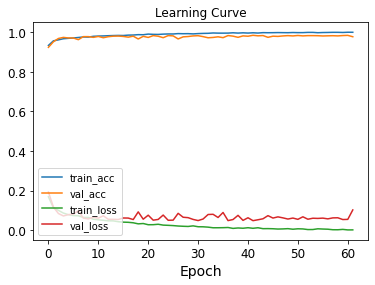

X_test .shape :  (6720, 27, 19, 1)
y_test .shape :  (6720, 2)




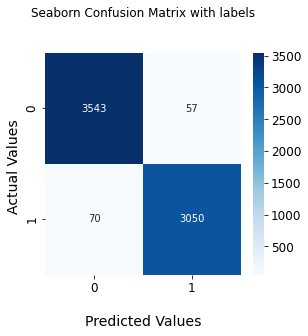

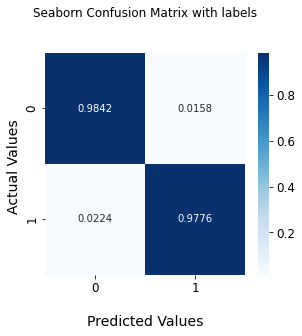

model_name :  2022-06-20_02_54


In [125]:
#normal 을 0으로
batch_size= 64
shape = (-1,27,19,1)
label = [0,1]
out_num = len(label)
X,y,submit = remake_data()
# X=np.concatenate((X[:3600,1:140],X[:3600,240:321],X[:3600,400:500]),axis = 1)
# submit_test=np.concatenate((submit_test[:,1:140],submit_test[:,240:321],submit_test[:,400:500]),axis = 1)
# X=X[-12000:]
# y= y[-12000:]
# print(X.reshape(shape).shape)


# y_train = ohe.fit_transform(y_train.values.reshape(-1,1))

p=PreProcessing()
y[y==0]=1
y[y==1]=1
y[y==3]=1
y[y==4]=1
y[y==2]=0

prep = {'X' : X, 'y': y, 'submit': submit,'shape' : shape,'label':None }
X_train,X_test,y_train,y_test,submit = p.pipeline(**prep)



input_shape = (X_train.shape[1],X_train.shape[2],1)
model = keras.models.Sequential([
    keras.Input(shape=input_shape),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(128, kernel_size=5, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(64, activation='relu'), #F6
    keras.layers.Dense(out_num, activation='softmax') #Output layer
    ])

model.summary()


train_par ={
#     'model':model, 'X_train':X_train, 'y_train':y_train, 'X_test':X_test,
#         'y_test':y_test, 'submit':submit,
        'batch_size':64, 'optimizer':'sgd', 'epoch':100, 'class_weight':True,
        'loss': 'categorical_crossentropy','patience':20}

T=Train_model(**train_par)
model_no, y_pred_no = T.compile_fit(model, X_train,y_train,X_test,y_test)

In [267]:
#normal은 빼고, in/out 을 1로
batch_size= 64
shape = (-1,27,19,1)
label = [0,1]
out_num = len(label)
X,y,submit = remake_data()
# X=np.concatenate((X[:3600,1:140],X[:3600,240:321],X[:3600,400:500]),axis = 1)
# submit_test=np.concatenate((submit_test[:,1:140],submit_test[:,240:321],submit_test[:,400:500]),axis = 1)
# X=X[-12000:]
# y= y[-12000:]
# print(X.reshape(shape).shape)


# y_train = ohe.fit_transform(y_train.values.reshape(-1,1))
p=PreProcessing()
X,y = p.drop_train(X,y,2)
p.data_shape(X,y)

y[y==0]=0
y[y==1]=0
y[y==3]=1
y[y==4]=1

prep = {'X' : X, 'y': y, 'submit': submit,'shape' : shape,'label':label }

X_train,X_test,y_train,y_test,submit = p.pipeline(**prep)



input_shape = (X_train.shape[1],X_train.shape[2],1)
model = keras.models.Sequential([
    keras.Input(shape=input_shape),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(128, kernel_size=5, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(64, activation='relu'), #F6
    keras.layers.Dense(out_num, activation='softmax') #Output layer
    ])

model.summary()


train_par ={
#     'model':model, 'X_train':X_train, 'y_train':y_train, 'X_test':X_test,
#         'y_test':y_test, 'submit':submit,
        'batch_size':64, 'optimizer':'sgd', 'epoch':100, 'class_weight':True,
        'loss': 'categorical_crossentropy','patience':20}

T=Train_model(**train_par)
model_no, y_pred_no = T.compile_fit(model, X_train,y_train,X_test,y_test)

X .shape :  (15600, 513)
y .shape :  (15600,)


[0 1]
X .shape :  (15600, 513)
y .shape :  (15600, 2)


(-1, 27, 19, 1)
X_train .shape :  (12480, 27, 19, 1)
X_test .shape :  (3120, 27, 19, 1)
y_train .shape :  (12480, 2)
y_test .shape :  (3120, 2)
submit .shape :  (7820, 27, 19, 1)


Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_198 (Bat (None, 27, 19, 1)         4         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 27, 19, 16)        416       
_________________________________________________________________
batch_normalization_199 (Bat (None, 27, 19, 16)        64        
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 13, 9, 16)         0         
_________________________________________________________________
conv2d_127 (Conv2D)          (No

KeyboardInterrupt: 

X .shape :  (3600, 513)
y .shape :  (3600,)


[0 1]
0 :  1800 1 :  1800
X .shape :  (3600, 513)
y .shape :  (3600, 2)


X_train .shape :  (2880, 27, 19, 1)
X_test .shape :  (720, 27, 19, 1)
y_train .shape :  (2880, 2)
y_test .shape :  (720, 2)
submit .shape :  (7820, 27, 19, 1)


Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_156 (Bat (None, 27, 19, 1)         4         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 27, 19, 16)        416       
_________________________________________________________________
batch_normalization_157 (Bat (None, 27, 19, 16)        64        
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 13, 9, 16)         0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 

Epoch 43/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0545 - accuracy: 0.9831 - val_loss: 0.4693 - val_accuracy: 0.8490
Epoch 44/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0520 - accuracy: 0.9850 - val_loss: 0.4653 - val_accuracy: 0.8507
Epoch 45/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0597 - accuracy: 0.9817 - val_loss: 0.4715 - val_accuracy: 0.8490
Epoch 46/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0732 - accuracy: 0.9750 - val_loss: 0.4508 - val_accuracy: 0.8576
Epoch 47/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0455 - accuracy: 0.9838 - val_loss: 0.4682 - val_accuracy: 0.8559
Epoch 48/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0371 - accuracy: 0.9913 - val_loss: 0.4558 - val_accuracy: 0.8507
Epoch 49/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0447 - accuracy: 0.9868 - val_loss: 0.4972 - val_accuracy: 0.8316

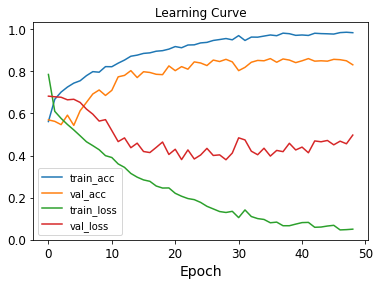

X_test .shape :  (720, 27, 19, 1)
y_test .shape :  (720, 2)




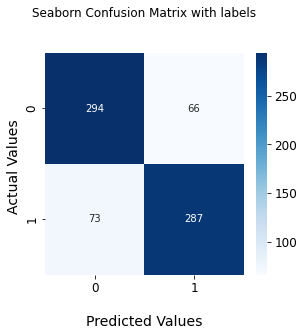

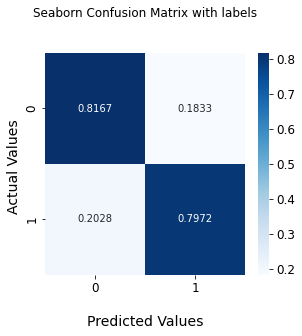

model_name :  2022-06-20_03_01


In [126]:
# in-------out 을 1로
batch_size= 64
shape = (-1,27,19,1)
label = [0,1]
out_num = len(label)
X,y,submit = remake_data()
# X=np.concatenate((X[:3600,1:140],X[:3600,240:321],X[:3600,400:500]),axis = 1)
# submit_test=np.concatenate((submit_test[:,1:140],submit_test[:,240:321],submit_test[:,400:500]),axis = 1)
# X=X[-12000:]
# y= y[-12000:]
# print(X.reshape(shape).shape)


# y_train = ohe.fit_transform(y_train.values.reshape(-1,1))
p=PreProcessing()
X,y = p.drop_train(X,y,2)
X,y = p.drop_train(X,y,3)
X,y = p.drop_train(X,y,4)

p.data_shape(X,y)

y[y==0]=0
y[y==1]=1


prep = {'X' : X, 'y': y, 'submit': submit,'shape' : shape,'label':label }

X_train,X_test,y_train,y_test,submit = p.pipeline(**prep)



input_shape = (X_train.shape[1],X_train.shape[2],1)
model = keras.models.Sequential([
    keras.Input(shape=input_shape),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(128, kernel_size=5, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(64, activation='relu'), #F6
    keras.layers.Dense(out_num, activation='softmax') #Output layer
    ])

model.summary()


train_par ={
#     'model':model, 'X_train':X_train, 'y_train':y_train, 'X_test':X_test,
#         'y_test':y_test, 'submit':submit,
        'batch_size':64, 'optimizer':'sgd', 'epoch':100, 'class_weight':True,
        'loss': 'categorical_crossentropy','patience':20}

T=Train_model(**train_par)
model_no, y_pred_no = T.compile_fit(model, X_train,y_train,X_test,y_test)

X .shape :  (12000, 513)
y .shape :  (12000,)


[0 1]
0 :  7000 1 :  5000
X .shape :  (12000, 513)
y .shape :  (12000, 2)


X_train .shape :  (9600, 27, 19, 1)
X_test .shape :  (2400, 27, 19, 1)
y_train .shape :  (9600, 2)
y_test .shape :  (2400, 2)
submit .shape :  (7820, 27, 19, 1)


Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_160 (Bat (None, 27, 19, 1)         4         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 27, 19, 16)        416       
_________________________________________________________________
batch_normalization_161 (Bat (None, 27, 19, 16)        64        
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 13, 9, 16)         0         
_________________________________________________________________
conv2d_121 (Conv2D)          (

120/120 [==============================] - 1s 10ms/step - loss: 0.0308 - accuracy: 0.9894 - val_loss: 0.1214 - val_accuracy: 0.9615
Epoch 43/100
120/120 [==============================] - 1s 10ms/step - loss: 0.0317 - accuracy: 0.9886 - val_loss: 0.1241 - val_accuracy: 0.9583
Epoch 44/100
120/120 [==============================] - 1s 10ms/step - loss: 0.0293 - accuracy: 0.9884 - val_loss: 0.1344 - val_accuracy: 0.9547
Epoch 45/100
120/120 [==============================] - 1s 10ms/step - loss: 0.0207 - accuracy: 0.9939 - val_loss: 0.1525 - val_accuracy: 0.9495
Epoch 46/100
120/120 [==============================] - 1s 10ms/step - loss: 0.0292 - accuracy: 0.9914 - val_loss: 0.1357 - val_accuracy: 0.9573
Epoch 47/100
120/120 [==============================] - 1s 10ms/step - loss: 0.0274 - accuracy: 0.9904 - val_loss: 0.1256 - val_accuracy: 0.9615
Epoch 48/100
120/120 [==============================] - 1s 10ms/step - loss: 0.0175 - accuracy: 0.9958 - val_loss: 0.1355 - val_accuracy: 0.952

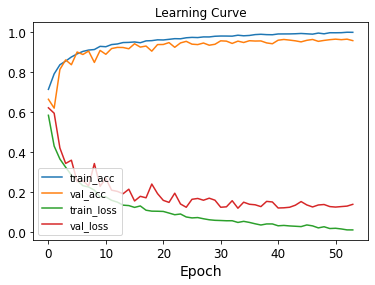

X_test .shape :  (2400, 27, 19, 1)
y_test .shape :  (2400, 2)




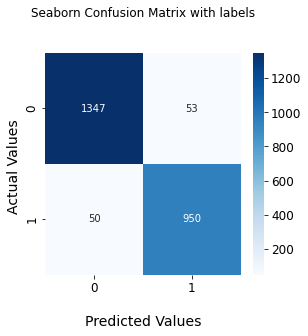

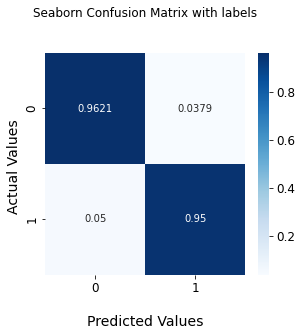

model_name :  2022-06-20_03_03


In [127]:
# in-------out 을 1로
batch_size= 64
shape = (-1,27,19,1)
label = [0,1]
out_num = len(label)
X,y,submit = remake_data()
# X=np.concatenate((X[:3600,1:140],X[:3600,240:321],X[:3600,400:500]),axis = 1)
# submit_test=np.concatenate((submit_test[:,1:140],submit_test[:,240:321],submit_test[:,400:500]),axis = 1)
# X=X[-12000:]
# y= y[-12000:]
# print(X.reshape(shape).shape)


# y_train = ohe.fit_transform(y_train.values.reshape(-1,1))
p=PreProcessing()
X,y = p.drop_train(X,y,2)
X,y = p.drop_train(X,y,1)
X,y = p.drop_train(X,y,0)

p.data_shape(X,y)

y[y==3]=0
y[y==4]=1


prep = {'X' : X, 'y': y, 'submit': submit,'shape' : shape,'label':label }

X_train,X_test,y_train,y_test,submit = p.pipeline(**prep)



input_shape = (X_train.shape[1],X_train.shape[2],1)
model = keras.models.Sequential([
    keras.Input(shape=input_shape),
    layers.BatchNormalization(),
#     keras.layers.experimental.preprocessing.Resizing(32,32),
    keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    keras.layers.Conv2D(128, kernel_size=5, strides=1, activation='relu', padding='same'), #C5
    layers.BatchNormalization(),
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(64, activation='relu'), #F6
    keras.layers.Dense(out_num, activation='softmax') #Output layer
    ])

model.summary()


train_par ={
#     'model':model, 'X_train':X_train, 'y_train':y_train, 'X_test':X_test,
#         'y_test':y_test, 'submit':submit,
        'batch_size':64, 'optimizer':'sgd', 'epoch':100, 'class_weight':True,
        'loss': 'categorical_crossentropy','patience':20}

T=Train_model(**train_par)
model_no, y_pred_no = T.compile_fit(model, X_train,y_train,X_test,y_test)

In [268]:
X,y,submit = remake_data()
prep = {'X' : X, 'y': y, 'submit': submit,'shape' : shape,'label':None }

X_train,X_test,y_train,y_test,submit = p.pipeline(**prep)


[0 1 2 3 4]
X .shape :  (33600, 513)
y .shape :  (33600, 5)


(-1, 27, 19, 1)
X_train .shape :  (26880, 27, 19, 1)
X_test .shape :  (6720, 27, 19, 1)
y_train .shape :  (26880, 5)
y_test .shape :  (6720, 5)
submit .shape :  (7820, 27, 19, 1)




In [139]:
X_test.shape

(6720, 27, 19, 1)

(33600, 513)
[0 1 2 3 4]
X .shape :  (33600, 513)
y .shape :  (33600, 5)


(-1, 27, 19, 1)
X_train .shape :  (26880, 27, 19, 1)
X_test .shape :  (6720, 27, 19, 1)
y_train .shape :  (26880, 5)
y_test .shape :  (6720, 5)
submit .shape :  (7820, 27, 19, 1)


[1 2]
(6720,)

----
pred 2 : [0 1]
(3139,)
[1 2]
(6720,)

----
[0 1]
(724,)
[0 2 3]
(6720,)

----
[0 1]
(2415,)
[0 1 2 3 4]
(6720,)

----
show_matrix :  (6720,) (6720,)


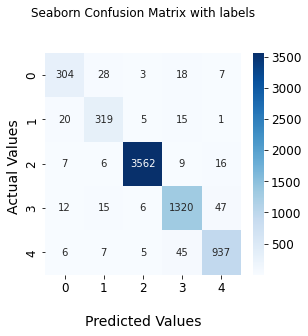

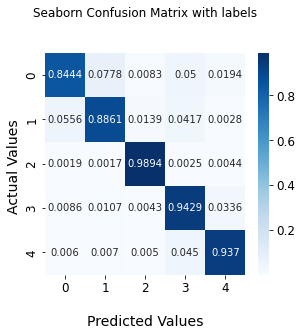

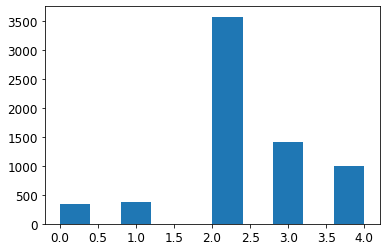


-----macro f1 score :  0.9182816494762724


(array([1407.,    0.,  375.,    0.,    0., 3581.,    0., 1008.,    0.,
         349.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

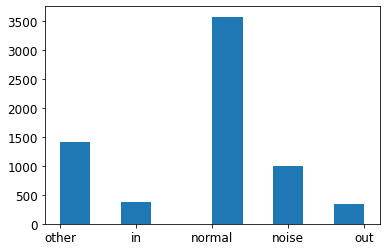

In [307]:
batch_size= 64
shape = (-1,27,19,1)
label = [0,1]
out_num = len(label)

X,y,submit = remake_data()
prep = {'X' : X, 'y': y, 'submit': submit,'shape' : shape,'label':None }
print(X.shape)
X_train,X_test,y_train,y_test,submit = p.pipeline(**prep)

sample_pd = pd.read_csv("D:/2022AIComp_data/sample_submission.csv")
sample_pd.set_index('id',inplace=True)


submit_te=X_test


model_1 = tf.keras.models.load_model('./model_flow/'+'2022-06-20_02_54'+'.hdf5')
model_2 = tf.keras.models.load_model('./model_flow/'+'2022-06-20_02_48'+'.hdf5')
model_3 = tf.keras.models.load_model('./model_flow/'+'2022-06-20_03_01'+'.hdf5')
model_4 = tf.keras.models.load_model('./model_flow/'+'2022-06-20_03_03'+'.hdf5')

#normal 구분
pred_1 = np.argmax(model_1.predict(submit_te),axis = 1)
pred_1[pred_1==0]=2

print(np.unique(pred_1))
print(pred_1.shape)
print('\n----')
##여기부터 step 2 in/out --- othor,normal
submit_2_ind = np.where(pred_1!=2)[0]# step 2에 들어갈 X_test index
submit_te_2 = submit_te[submit_2_ind] #step 2에 들어갈 X_test


pred_2 = np.argmax(model_2.predict(submit_te_2),axis = 1)
print('pred 2 :', np.unique(pred_2))
print(pred_2.shape)

pred_2[pred_2 == 0]= 3
pred_2[pred_2 == 1]= 0

print(np.unique(pred_1))
pred_1[submit_2_ind]= pred_2
print(pred_1.shape)
np.unique(pred_1)

print('\n----')


####여기부터 step  in---out
submit_3_ind = np.where(pred_1==0)[0]# step 2에 들어갈 X_test index
submit_te_3 = submit_te[submit_3_ind] #step 2에 들어갈 X_test

pred_3 = np.argmax(model_3.predict(submit_te_3),axis = 1)
print(np.unique(pred_3))
print(pred_3.shape)
pred_3[pred_3 == 0]= 0
pred_3[pred_3 == 1]= 1
print(np.unique(pred_1))
pred_1[submit_3_ind]= pred_3
print(pred_1.shape)
np.unique(pred_1)


print('\n----')


####여기부터 step  in---out
submit_4_ind = np.where(pred_1==3)[0]# step 2에 들어갈 X_test index
submit_te_4 = submit_te[submit_4_ind] #step 2에 들어갈 X_test

pred_4 = np.argmax(model_4.predict(submit_te_4),axis = 1)
print(np.unique(pred_4))
print(pred_4.shape)
pred_4[pred_4 == 0]= 3
pred_4[pred_4 == 1]= 4
# print(np.unique(pred_1))
pred_1[submit_4_ind]= pred_4
print(np.unique(pred_1))

print(pred_1.shape)




print('\n----')




show_matrix(np.argmax(y_test,axis=1),pred_1)
plt.hist(np.array(pred_1))
plt.show()
pred_pd = pd.DataFrame(pred_1,columns=['leaktype']).replace([0,1,2,3,4],
                ['out','in', 'normal', 'other', 'noise'])


from sklearn.metrics import f1_score
print('\n-----macro f1 score : ',f1_score(np.argmax(y_test,axis=1), pred_1, average='macro'))
    
plt.hist(np.array(pred_pd))

# print('train_acc : ', pred_1[pred_1==label].shape[0]/pred_1.shape[0])

# sub = pd.concat([test_pd.iloc[:,0],
#                        pd.DataFrame(pred_1,columns=['leaktype']).replace([0,1,2,3,4],['out','in', 'normal', 'other', 'noise'])],axis=1)

# sub.set_index('id',inplace=True)
# submit_pd = sub.reindex(sample_pd.index)
# print('제출 할 csv 클래스 별 분포 : ', submit_pd.value_counts())
# plt.hist(np.array(pred_1))
# plt.show()

# MODEL_SAVE_FOLDER_PATH = './result_csv/' 
# if not os.path.exists(MODEL_SAVE_FOLDER_PATH): 
#     os.mkdir(MODEL_SAVE_FOLDER_PATH) 
# submit_pd.to_csv(MODEL_SAVE_FOLDER_PATH + 'OVO.csv')
# print('저장 파일 이름', MODEL_SAVE_FOLDER_PATH + 'OVO.csv')



[1 2]
(7820,)

----
pred 2 : [0 1]
(5256,)
[1 2]
(7820,)

----
[   2    3   11 ... 7810 7812 7816]
[0 1]
(3100,)
[0 2 3]
(7820,)

----
[0 1]
(2156,)
[0 1 2 3 4]
(7820,)

----
train_acc :  0.0
제출 할 csv 클래스 별 분포 :  leaktype
normal      2564
out         1708
in          1392
other       1241
noise        915
dtype: int64


C:\Users\GJ\AppData\Local\Temp\ipykernel_17336\2843499246.py:84: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print('train_acc : ', pred_1[pred_1==label].shape[0]/pred_1.shape[0])


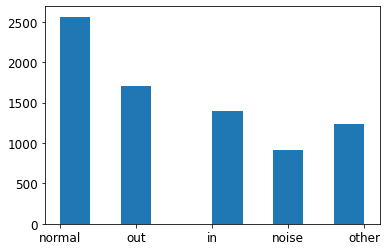

저장 파일 이름 ./result_csv/OVO.csv


In [322]:
sample_pd = pd.read_csv("D:/2022AIComp_data/sample_submission.csv")
sample_pd.set_index('id',inplace=True)


submit_te=submit


model_1 = tf.keras.models.load_model('./model_flow/'+'2022-06-20_02_54'+'.hdf5')
model_2 = tf.keras.models.load_model('./model_flow/'+'2022-06-20_02_48'+'.hdf5')
model_3 = tf.keras.models.load_model('./model_flow/'+'2022-06-20_03_01'+'.hdf5')
model_4 = tf.keras.models.load_model('./model_flow/'+'2022-06-20_03_03'+'.hdf5')

#normal 구분
pred_1 = np.argmax(model_1.predict(submit_te),axis = 1)
pred_1[pred_1==0]=2

print(np.unique(pred_1))
print(pred_1.shape)
print('\n----')
##여기부터 step 2 in/out --- othor,normal
submit_2_ind = np.where(pred_1!=2)[0]# step 2에 들어갈 X_test index
submit_te_2 = submit_te[submit_2_ind] #step 2에 들어갈 X_test


pred_2 = np.argmax(model_2.predict(submit_te_2),axis = 1)
print('pred 2 :', np.unique(pred_2))
print(pred_2.shape)

pred_2[pred_2 == 0]= 3
pred_2[pred_2 == 1]= 0

print(np.unique(pred_1))
pred_1[submit_2_ind]= pred_2
print(pred_1.shape)
np.unique(pred_1)

print('\n----')


####여기부터 step  in---out
submit_3_ind = np.where(pred_1==0)[0]# step 2에 들어갈 X_test index
print(submit_3_ind)
submit_te_3 = submit_te[submit_3_ind] #step 2에 들어갈 X_test

pred_3 = np.argmax(model_3.predict(submit_te_3),axis = 1)
print(np.unique(pred_3))
print(pred_3.shape)
pred_3[pred_3 == 0]= 0
pred_3[pred_3 == 1]= 1
print(np.unique(pred_1))
pred_1[submit_3_ind]= pred_3
print(pred_1.shape)
np.unique(pred_1)


print('\n----')


####여기부터 step  in---out
submit_4_ind = np.where(pred_1==3)[0]# step 2에 들어갈 X_test index
submit_te_4 = submit_te[submit_4_ind] #step 2에 들어갈 X_test

pred_4 = np.argmax(model_4.predict(submit_te_4),axis = 1)
print(np.unique(pred_4))
print(pred_4.shape)
pred_4[pred_4 == 0]= 3
pred_4[pred_4 == 1]= 4
# print(np.unique(pred_1))
pred_1[submit_4_ind]= pred_4
print(np.unique(pred_1))

print(pred_1.shape)




print('\n----')




# show_matrix(y_test,pred_1)

print('train_acc : ', pred_1[pred_1==label].shape[0]/pred_1.shape[0])

sub = pd.concat([test_pd.iloc[:,0],
                       pd.DataFrame(pred_1,columns=['leaktype']).replace([0,1,2,3,4],['out','in', 'normal', 'other', 'noise'])],axis=1)



sub.set_index('id',inplace=True)
submit_pd = sub.reindex(sample_pd.index)
print('제출 할 csv 클래스 별 분포 : ', submit_pd.value_counts())
plt.hist(np.array(submit_pd))
plt.show()

MODEL_SAVE_FOLDER_PATH = './result_csv/' 
if not os.path.exists(MODEL_SAVE_FOLDER_PATH): 
    os.mkdir(MODEL_SAVE_FOLDER_PATH) 
submit_pd.to_csv(MODEL_SAVE_FOLDER_PATH + 'OVO.csv')
print('저장 파일 이름', MODEL_SAVE_FOLDER_PATH + 'OVO.csv')




In [331]:
jung = np.array(test_correct.iloc[:,1])
pred = np.array(submit_pd['leaktype'])

In [333]:
len(pred[jung==pred])/len(pred)

0.8164961636828645

In [ ]:
sample_pd = pd.read_csv("D:/2022AIComp_data/sample_submission.csv")
sample_pd.set_index('id',inplace=True)


submit_te=submit


model_1 = tf.keras.models.load_model('./model_flow/'+'2022-06-20_02_54'+'.hdf5')
model_2 = tf.keras.models.load_model('./model_flow/'+'2022-06-20_02_48'+'.hdf5')
model_3 = tf.keras.models.load_model('./model_flow/'+'2022-06-20_03_01'+'.hdf5')
model_4 = tf.keras.models.load_model('./model_flow/'+'2022-06-20_03_03'+'.hdf5')

#normal 구분
pred_1 = np.argmax(model_1.predict(submit_te),axis = 1)
pred_1[pred_1==0]=2

print(np.unique(pred_1))
print(pred_1.shape)
print('\n----')
##여기부터 step 2 in/out --- othor,normal
submit_2_ind = np.where(pred_1!=2)[0]# step 2에 들어갈 X_test index
submit_te_2 = submit_te[submit_2_ind] #step 2에 들어갈 X_test


pred_2 = np.argmax(model_2.predict(submit_te_2),axis = 1)
print('pred 2 :', np.unique(pred_2))
print(pred_2.shape)

pred_2[pred_2 == 0]= 3
pred_2[pred_2 == 1]= 0

print(np.unique(pred_1))
pred_1[submit_2_ind]= pred_2
print(pred_1.shape)
np.unique(pred_1)

print('\n----')


####여기부터 step  in---out
submit_3_ind = np.where(pred_1==0)[0]# step 2에 들어갈 X_test index
print(submit_3_ind)
submit_te_3 = submit_te[submit_3_ind] #step 2에 들어갈 X_test

pred_3 = np.argmax(model_3.predict(submit_te_3),axis = 1)
print(np.unique(pred_3))
print(pred_3.shape)
pred_3[pred_3 == 0]= 0
pred_3[pred_3 == 1]= 1
print(np.unique(pred_1))
pred_1[submit_3_ind]= pred_3
print(pred_1.shape)
np.unique(pred_1)


print('\n----')


####여기부터 step  in---out
submit_4_ind = np.where(pred_1==3)[0]# step 2에 들어갈 X_test index
submit_te_4 = submit_te[submit_4_ind] #step 2에 들어갈 X_test

pred_4 = np.argmax(model_4.predict(submit_te_4),axis = 1)
print(np.unique(pred_4))
print(pred_4.shape)
pred_4[pred_4 == 0]= 3
pred_4[pred_4 == 1]= 4
# print(np.unique(pred_1))
pred_1[submit_4_ind]= pred_4
print(np.unique(pred_1))

print(pred_1.shape)




print('\n----')




# show_matrix(y_test,pred_1)

print('train_acc : ', pred_1[pred_1==label].shape[0]/pred_1.shape[0])

# sub = pd.concat([test_pd.iloc[:,0],
#                        pd.DataFrame(pred_1,columns=['leaktype']).replace([0,1,2,3,4],['out','in', 'normal', 'other', 'noise'])],axis=1)



# sub.set_index('id',inplace=True)
# submit_pd = sub.reindex(sample_pd.index)
# print('제출 할 csv 클래스 별 분포 : ', submit_pd.value_counts())
# plt.hist(np.array(submit_pd))
# plt.show()

# MODEL_SAVE_FOLDER_PATH = './result_csv/' 
# if not os.path.exists(MODEL_SAVE_FOLDER_PATH): 
#     os.mkdir(MODEL_SAVE_FOLDER_PATH) 
# submit_pd.to_csv(MODEL_SAVE_FOLDER_PATH + 'OVO.csv')
# print('저장 파일 이름', MODEL_SAVE_FOLDER_PATH + 'OVO.csv')




In [323]:
print(sub)

           leaktype
id                 
A8omWrwmLF   normal
XEVCsLi6ps   normal
cEVCc0xZkC      out
M2a2qkpvQ4      out
Sts4cwqBEo   normal
...             ...
XPZiUyQPgg   normal
fLSro59Y12      out
C3guvrwoiN   normal
aU6pSfYjZG   normal
4eYAuaAagi    noise

[7820 rows x 1 columns]


In [318]:
sub

,leaktype
id,
A8omWrwmLF,normal
XEVCsLi6ps,normal
cEVCc0xZkC,out
M2a2qkpvQ4,out
Sts4cwqBEo,normal
...,...
XPZiUyQPgg,normal
fLSro59Y12,out
C3guvrwoiN,normal


In [313]:
idx = test_pd.iloc[:,0]

In [311]:
pred = pd.DataFrame(pred_1,columns=['leaktype']).replace([0,1,2,3,4],['out','in', 'normal', 'other', 'noise'])

In [317]:
sub = pd.concat([idx,pred],axis=1)
sub.set_index('id',inplace=True)
submit_pd = sub.reindex(sample_pd.index)
submit_pd

,leaktype
id,
gAbuQeZQCm,normal
4xtuwcJQI7,out
2LgOPmQb8u,normal
b6zEYLjs7Y,out
yaYY68O0xX,normal
...,...
ljOCzcR8HX,out
SdKATDrV3C,out
Lo3sZiFiew,noise


In [ ]:
sub = pd.concat([test_pd.iloc[:,0],
                       pd.DataFrame(pred_1,columns=['leaktype']).replace([0,1,2,3,4],['out','in', 'normal', 'other', 'noise'])],axis=1)


In [293]:
jung = test_correct.iloc[:,1]


0       normal
1          out
2       normal
3          out
4       normal
         ...  
7815       out
7816       out
7817     noise
7818        in
7819    normal
Name: leaktype, Length: 7820, dtype: object

In [304]:
for i in range(len(sub)):
    print(sub['leaktype'][i])

other
in
other
normal
normal
noise
normal
other
other
normal
other
normal
normal
normal
noise
normal
normal
other
normal
in
normal
normal
other
other
normal
normal
out
noise
normal
noise
other
normal
normal
noise
normal
other
normal
normal
normal
normal
normal
normal
normal
other
normal
normal
normal
other
normal
normal
normal
normal
other
normal
noise
other
normal
other
in
in
normal
other
other
normal
normal
normal
in
noise
noise
normal
normal
normal
noise
other
normal
noise
normal
normal
normal
normal
normal
normal
out
normal
other
normal
normal
normal
out
other
out
other
noise
normal
other
normal
normal
normal
out
noise
normal
normal
other
other
normal
normal
normal
noise
normal
normal
in
noise
normal
other
noise
normal
other
other
normal
other
other
other
normal
normal
normal
normal
normal
normal
normal
other
noise
normal
other
other
normal
normal
normal
normal
in
in
normal
other
in
in
noise
out
out
other
other
other
normal
in
normal
in
other
other
normal
other
out
other
normal
noi

In [226]:
def pipeline(**kwargs):
        p=PreProcessing()
        X=kwargs.get('X')
        y=kwargs.get('y')
        submit=kwargs.get('submit')
        shape = kwargs.get('shape')
#         label = kwargs.get('label')
        print(shape)
        
#         y = self.dummies(y)
#         self.y_real=y
        print(np.unique(y))
        X=p.make_max(X)
        submit=p.make_max(submit)
        
        print('0 : ', len(y[y==0]), '1 : ',len(y[y==1]) )

#         print('y : ',y)
#         X,y=self.make_label_set(X,y,label)

        y=np.array(pd.get_dummies(y))
    
        p.data_shape(X,y,local = locals())
#         print('y :', y)
        if shape is not None:
#             print(shape)
#             print(len(data))
            X,submit = p.data_reshape(X,submit,shape = shape)
#             print(len(res))
            
        X_train,X_test,y_train,y_test = p.split(X,y)
        p.data_shape(X_train,X_test,y_train,y_test,submit,local = locals())
        

        return X_train,X_test,y_train,y_test,submit

(-1, 515, 1)
[0 1 2 3 4]
[584 776 263 ... 838 348 708]
33600
33600
[151 358 791 ...  62 156 147]
7820
7820
0 :  1800 1 :  1800
X .shape :  (33600, 515)
y .shape :  (33600, 5)


(-1, 515, 1)
X_train .shape :  (26880, 515, 1)
X_test .shape :  (6720, 515, 1)
y_train .shape :  (26880, 5)
y_test .shape :  (6720, 5)
submit .shape :  (7820, 515, 1)


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        [(None, 515, 1)]          0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 515, 16)           96        
_________________________________________________________________
batch_normalization_189 (Bat (None, 515, 16)           64        
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 257, 16)           0         
___________________________________________

336/336 [==============================] - 8s 23ms/step - loss: 0.1023 - accuracy: 0.9725 - val_loss: 0.3186 - val_accuracy: 0.8996
Epoch 29/100
336/336 [==============================] - 8s 24ms/step - loss: 0.0900 - accuracy: 0.9758 - val_loss: 0.3271 - val_accuracy: 0.8971
Epoch 30/100
336/336 [==============================] - 8s 23ms/step - loss: 0.0823 - accuracy: 0.9776 - val_loss: 0.3178 - val_accuracy: 0.9016
Epoch 31/100
336/336 [==============================] - 8s 23ms/step - loss: 0.0856 - accuracy: 0.9778 - val_loss: 0.3259 - val_accuracy: 0.9010
Epoch 32/100
336/336 [==============================] - 8s 24ms/step - loss: 0.0747 - accuracy: 0.9804 - val_loss: 0.3205 - val_accuracy: 0.9027
Epoch 33/100
336/336 [==============================] - 8s 25ms/step - loss: 0.0692 - accuracy: 0.9817 - val_loss: 0.3192 - val_accuracy: 0.9014
Epoch 34/100
336/336 [==============================] - 8s 25ms/step - loss: 0.0638 - accuracy: 0.9816 - val_loss: 0.3143 - val_accuracy: 0.906

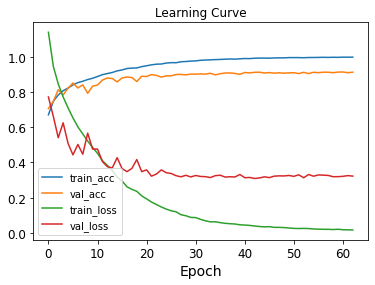

X_test .shape :  (6720, 515, 1)
y_test .shape :  (6720, 5)


(6720,) (6720,)
show_matrix :  (6720,) (6720,)


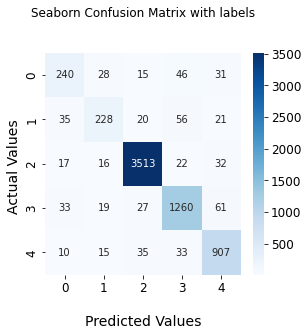

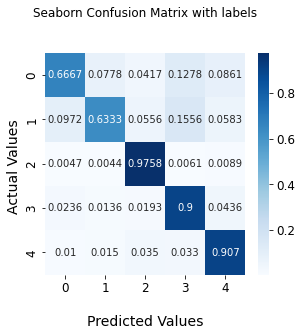


-----macro f1 score :  0.8256792680759653
model_name :  2022-06-20_17_16


In [243]:
batch_size= 64
shape = (-1,515,1)
# label = [0,1]
out_num = 5
X,y,submit = remake_data()
p=PreProcessing()


prep = {'X' : X, 'y': y, 'submit': submit,'shape' : shape,'label':None }

X_train,X_test,y_train,y_test,submit = pipeline(**prep)



# input_shape = (X_train.shape[1],X_train.shape[2],1)
# model = keras.models.Sequential([
#     keras.Input(shape=input_shape),
#     layers.BatchNormalization(),
# #     keras.layers.experimental.preprocessing.Resizing(32,32),
#     keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
#     layers.BatchNormalization(),
#     layers.MaxPool2D(),
#     keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
#     layers.BatchNormalization(),
#     layers.MaxPool2D(),
#     keras.layers.Conv2D(128, kernel_size=5, strides=1, activation='relu', padding='same'), #C5
#     layers.BatchNormalization(),
#     keras.layers.Flatten(), #Flatten    
#     keras.layers.Dense(64, activation='relu'), #F6
#     keras.layers.Dense(out_num, activation='softmax') #Output layer
#     ])


input_layer = keras.Input(shape = (515,1))
x=keras.layers.Conv1D(16, kernel_size=5,strides=1,  activation='relu', padding='same')(input_layer) #C11
x= layers.BatchNormalization()(x)

x=tf.keras.layers.MaxPool1D()(x)
x=keras.layers.Conv1D(64, kernel_size=5, strides=4, activation='relu', padding='valid')(x)
x= layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool1D()(x)
x=keras.layers.Conv1D(128, kernel_size=5, strides=1, activation='tanh', padding='valid')(x)
x= layers.BatchNormalization()(x)
x=keras.layers.Flatten()(x)
x=keras.layers.Dense(84, activation='tanh')(x)
out = keras.layers.Dense(5, activation='softmax')(x)

model = keras.Model(input_layer,out)
model.summary()


model.summary()


train_par ={
#     'model':model, 'X_train':X_train, 'y_train':y_train, 'X_test':X_test,
#         'y_test':y_test, 'submit':submit,
        'batch_size':64, 'optimizer':'sgd', 'epoch':100, 'class_weight':True,
        'loss': 'categorical_crossentropy','patience':20}

T=Train_model(**train_par)
model_no, y_pred_no = T.compile_fit(model, X_train,y_train,X_test,y_test)

In [283]:
X,y,submit = remake_data()
def portion_data(X,y):
    port = [1800,1200,1800,600,600]

    for i,j in enumerate(port):
        globals()['X_'+str(i)] = X[y==i][:j]
        globals()['y_'+str(i)] = y[y==i][:j]

    X_sub = [X_0,X_1,X_2,X_3,X_4]
    y_sub = [y_0,y_1,y_2,y_3,y_4]

    for i in X_sub:
        print(i.shape)


    X = np.concatenate((X_0,X_1,X_2,X_3,X_4),axis=0)
    y = np.concatenate((y_0,y_1,y_2,y_3,y_4),axis=0)
    return X,y

(1800, 513)
(1200, 513)
(1800, 513)
(600, 513)
(600, 513)
(-1, 515, 1)
[0 1 2 3 4]
[ 584  776  263 ...  792 1023  619]
6000
6000
[151 358 791 ...  62 156 147]
7820
7820
0 :  1800 1 :  1200
X .shape :  (6000, 515)
y .shape :  (6000, 5)


(-1, 515, 1)
X_train .shape :  (4800, 515, 1)
X_test .shape :  (1200, 515, 1)
y_train .shape :  (4800, 5)
y_test .shape :  (1200, 5)
submit .shape :  (7820, 515, 1)


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        [(None, 515, 1)]          0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 515, 16)           96        
_________________________________________________________________
batch_normalization_202 (Bat (None, 515, 16)           64        
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 257, 16)      

60/60 [==============================] - 4s 70ms/step - loss: 0.3007 - accuracy: 0.9176 - val_loss: 0.8243 - val_accuracy: 0.6938
Epoch 29/100
60/60 [==============================] - 5s 82ms/step - loss: 0.2931 - accuracy: 0.9216 - val_loss: 0.8107 - val_accuracy: 0.7052
Epoch 30/100
60/60 [==============================] - 4s 72ms/step - loss: 0.2889 - accuracy: 0.9239 - val_loss: 0.8756 - val_accuracy: 0.6844
Epoch 31/100
60/60 [==============================] - 5s 91ms/step - loss: 0.2761 - accuracy: 0.9293 - val_loss: 0.7933 - val_accuracy: 0.7125
Epoch 32/100
60/60 [==============================] - 6s 94ms/step - loss: 0.2504 - accuracy: 0.9376 - val_loss: 0.8552 - val_accuracy: 0.6990
Epoch 33/100
60/60 [==============================] - 4s 69ms/step - loss: 0.2449 - accuracy: 0.9431 - val_loss: 0.8051 - val_accuracy: 0.7177
Epoch 34/100
60/60 [==============================] - 5s 81ms/step - loss: 0.2288 - accuracy: 0.9470 - val_loss: 0.8145 - val_accuracy: 0.7021
Epoch 35/100

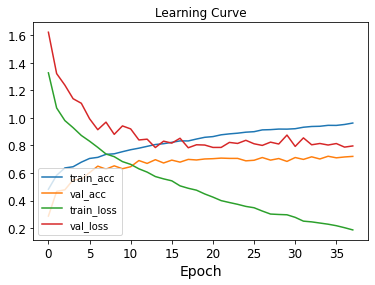

X_test .shape :  (1200, 515, 1)
y_test .shape :  (1200, 5)


(1200,) (1200,)
show_matrix :  (1200,) (1200,)


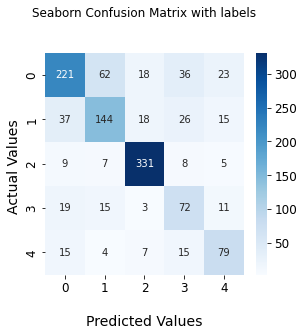

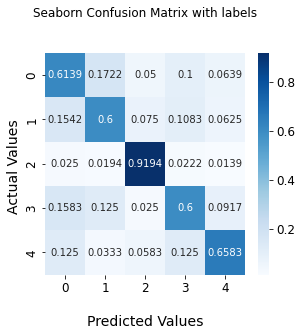


-----macro f1 score :  0.6642901841436875
model_name :  2022-06-20_18_51


In [284]:
batch_size= 64
shape = (-1,515,1)
# label = [0,1]
out_num = 5
X,y,submit = remake_data()

X,y = portion_data(X,y)


p=PreProcessing()


prep = {'X' : X, 'y': y, 'submit': submit,'shape' : shape,'label':None }

X_train,X_test,y_train,y_test,submit = pipeline(**prep)



# input_shape = (X_train.shape[1],X_train.shape[2],1)
# model = keras.models.Sequential([
#     keras.Input(shape=input_shape),
#     layers.BatchNormalization(),
# #     keras.layers.experimental.preprocessing.Resizing(32,32),
#     keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
#     layers.BatchNormalization(),
#     layers.MaxPool2D(),
#     keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
#     layers.BatchNormalization(),
#     layers.MaxPool2D(),
#     keras.layers.Conv2D(128, kernel_size=5, strides=1, activation='relu', padding='same'), #C5
#     layers.BatchNormalization(),
#     keras.layers.Flatten(), #Flatten    
#     keras.layers.Dense(64, activation='relu'), #F6
#     keras.layers.Dense(out_num, activation='softmax') #Output layer
#     ])


input_layer = keras.Input(shape = (515,1))
x=keras.layers.Conv1D(16, kernel_size=5,strides=1,  activation='relu', padding='same')(input_layer) #C11
x= layers.BatchNormalization()(x)

x=tf.keras.layers.MaxPool1D()(x)
x=keras.layers.Conv1D(64, kernel_size=5, strides=4, activation='relu', padding='valid')(x)
x= layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool1D()(x)
x=keras.layers.Conv1D(128, kernel_size=5, strides=1, activation='tanh', padding='valid')(x)
x= layers.BatchNormalization()(x)
x=keras.layers.Flatten()(x)
x=keras.layers.Dense(84, activation='tanh')(x)
out = keras.layers.Dense(5, activation='softmax')(x)

model = keras.Model(input_layer,out)
model.summary()


model.summary()


train_par ={
#     'model':model, 'X_train':X_train, 'y_train':y_train, 'X_test':X_test,
#         'y_test':y_test, 'submit':submit,
        'batch_size':64, 'optimizer':'sgd', 'epoch':100, 'class_weight':True,
        'loss': 'categorical_crossentropy','patience':20}

T=Train_model(**train_par)
model_no, y_pred_no = T.compile_fit(model, X_train,y_train,X_test,y_test)

In [ ]:
batch_size= 64
shape = (-1,515,1)
# label = [0,1]
out_num = 5
X,y,submit = remake_data()

X,y = portion_data(X,y)


p=PreProcessing()


prep = {'X' : X, 'y': y, 'submit': submit,'shape' : shape,'label':None }

X_train,X_test,y_train,y_test,submit = pipeline(**prep)



# input_shape = (X_train.shape[1],X_train.shape[2],1)
# model = keras.models.Sequential([
#     keras.Input(shape=input_shape),
#     layers.BatchNormalization(),
# #     keras.layers.experimental.preprocessing.Resizing(32,32),
#     keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
#     layers.BatchNormalization(),
#     layers.MaxPool2D(),
#     keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
#     layers.BatchNormalization(),
#     layers.MaxPool2D(),
#     keras.layers.Conv2D(128, kernel_size=5, strides=1, activation='relu', padding='same'), #C5
#     layers.BatchNormalization(),
#     keras.layers.Flatten(), #Flatten    
#     keras.layers.Dense(64, activation='relu'), #F6
#     keras.layers.Dense(out_num, activation='softmax') #Output layer
#     ])


input_layer = keras.Input(shape = (515,1))
x=keras.layers.Conv1D(16, kernel_size=5,strides=1,  activation='relu', padding='same')(input_layer) #C11
x= layers.BatchNormalization()(x)

x=tf.keras.layers.MaxPool1D()(x)
x=keras.layers.Conv1D(64, kernel_size=5, strides=4, activation='relu', padding='valid')(x)
x= layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool1D()(x)
x=keras.layers.Conv1D(128, kernel_size=5, strides=1, activation='tanh', padding='valid')(x)
x= layers.BatchNormalization()(x)
x=keras.layers.Flatten()(x)
x=keras.layers.Dense(84, activation='tanh')(x)
out = keras.layers.Dense(5, activation='softmax')(x)

model = keras.Model(input_layer,out)
model.summary()


model.summary()


train_par ={
#     'model':model, 'X_train':X_train, 'y_train':y_train, 'X_test':X_test,
#         'y_test':y_test, 'submit':submit,
        'batch_size':64, 'optimizer':'sgd', 'epoch':100, 'class_weight':None,
        'loss': 'categorical_crossentropy','patience':20}

T=Train_model(**train_par)
model_no, y_pred_no = T.compile_fit(model, X_train,y_train,X_test,y_test)

(-1, 515, 1)
[0 1 2 3 4]
[584 776 263 ... 838 348 708]
33600
33600
[151 358 791 ...  62 156 147]
7820
7820
0 :  1800 1 :  1800
X .shape :  (33600, 515)
y .shape :  (33600, 5)


(-1, 515, 1)
X_train .shape :  (26880, 515, 1)
X_test .shape :  (6720, 515, 1)
y_train .shape :  (26880, 5)
y_test .shape :  (6720, 5)
submit .shape :  (7820, 515, 1)


Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        [(None, 515, 1)]          0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 515, 16)           96        
_________________________________________________________________
batch_normalization_195 (Bat (None, 515, 16)           64        
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 257, 16)           0         
__________________________________________

336/336 [==============================] - 8s 24ms/step - loss: 0.0149 - accuracy: 0.8577 - val_loss: 0.0165 - val_accuracy: 0.8508
Epoch 29/100
336/336 [==============================] - 8s 25ms/step - loss: 0.0147 - accuracy: 0.8655 - val_loss: 0.0164 - val_accuracy: 0.8499
Epoch 30/100
336/336 [==============================] - 8s 24ms/step - loss: 0.0147 - accuracy: 0.8688 - val_loss: 0.0165 - val_accuracy: 0.8516
Epoch 31/100
336/336 [==============================] - 8s 25ms/step - loss: 0.0145 - accuracy: 0.8690 - val_loss: 0.0162 - val_accuracy: 0.8503
Epoch 32/100
336/336 [==============================] - 8s 25ms/step - loss: 0.0145 - accuracy: 0.8693 - val_loss: 0.0160 - val_accuracy: 0.8534
Epoch 33/100
336/336 [==============================] - 9s 26ms/step - loss: 0.0145 - accuracy: 0.8692 - val_loss: 0.0160 - val_accuracy: 0.8553
Epoch 34/100
336/336 [==============================] - 8s 25ms/step - loss: 0.0145 - accuracy: 0.8729 - val_loss: 0.0160 - val_accuracy: 0.852

336/336 [==============================] - 8s 24ms/step - loss: 0.0099 - accuracy: 0.9207 - val_loss: 0.0137 - val_accuracy: 0.8836
Epoch 85/100
336/336 [==============================] - 10s 30ms/step - loss: 0.0099 - accuracy: 0.9199 - val_loss: 0.0135 - val_accuracy: 0.8828
Epoch 86/100
336/336 [==============================] - 8s 24ms/step - loss: 0.0101 - accuracy: 0.9184 - val_loss: 0.0135 - val_accuracy: 0.8836
Epoch 87/100
336/336 [==============================] - 8s 24ms/step - loss: 0.0096 - accuracy: 0.9203 - val_loss: 0.0136 - val_accuracy: 0.8832
Epoch 88/100
336/336 [==============================] - 8s 24ms/step - loss: 0.0095 - accuracy: 0.9237 - val_loss: 0.0133 - val_accuracy: 0.8841
Epoch 89/100
336/336 [==============================] - 8s 24ms/step - loss: 0.0094 - accuracy: 0.9231 - val_loss: 0.0134 - val_accuracy: 0.8875
Epoch 90/100
336/336 [==============================] - 8s 24ms/step - loss: 0.0092 - accuracy: 0.9237 - val_loss: 0.0135 - val_accuracy: 0.88

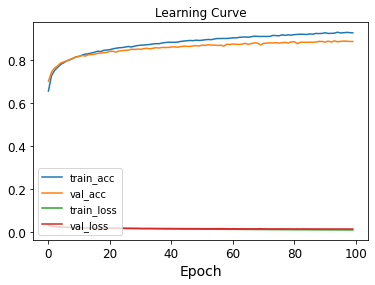

X_test .shape :  (6720, 515, 1)
y_test .shape :  (6720, 5)


(6720,) (6720,)
show_matrix :  (6720,) (6720,)


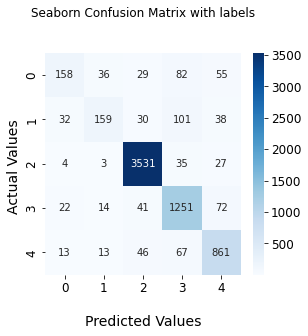

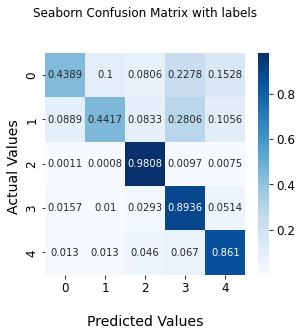


-----macro f1 score :  0.7482999025140324
model_name :  2022-06-20_17_30


In [254]:
batch_size= 64
shape = (-1,515,1)
# label = [0,1]
out_num = 5
X,y,submit = remake_data()
p=PreProcessing()


prep = {'X' : X, 'y': y, 'submit': submit,'shape' : shape,'label':None }

X_train,X_test,y_train,y_test,submit = pipeline(**prep)



# input_shape = (X_train.shape[1],X_train.shape[2],1)
# model = keras.models.Sequential([
#     keras.Input(shape=input_shape),
#     layers.BatchNormalization(),
# #     keras.layers.experimental.preprocessing.Resizing(32,32),
#     keras.layers.Conv2D(16, kernel_size=5, strides=1,  activation='relu', padding='same'), #C11
#     layers.BatchNormalization(),
#     layers.MaxPool2D(),
#     keras.layers.Conv2D(64, kernel_size=5, strides=1, activation='relu', padding='same'), #C3
#     layers.BatchNormalization(),
#     layers.MaxPool2D(),
#     keras.layers.Conv2D(128, kernel_size=5, strides=1, activation='relu', padding='same'), #C5
#     layers.BatchNormalization(),
#     keras.layers.Flatten(), #Flatten    
#     keras.layers.Dense(64, activation='relu'), #F6
#     keras.layers.Dense(out_num, activation='softmax') #Output layer
#     ])


input_layer = keras.Input(shape = (515,1))
x=keras.layers.Conv1D(16, kernel_size=5,strides=1,  activation='relu', padding='same')(input_layer) #C11
x= layers.BatchNormalization()(x)

x=tf.keras.layers.MaxPool1D()(x)
x=keras.layers.Conv1D(64, kernel_size=5, strides=4, activation='relu', padding='valid')(x)
x= layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPool1D()(x)
x=keras.layers.Conv1D(128, kernel_size=5, strides=1, activation='tanh', padding='valid')(x)
x= layers.BatchNormalization()(x)
x=keras.layers.Flatten()(x)
x=keras.layers.Dense(84, activation='tanh')(x)
out = keras.layers.Dense(5, activation='softmax')(x)

model = keras.Model(input_layer,out)
model.summary()


model.summary()


train_par ={
#     'model':model, 'X_train':X_train, 'y_train':y_train, 'X_test':X_test,
#         'y_test':y_test, 'submit':submit,
        'batch_size':64, 'optimizer':'sgd', 'epoch':1000, 'class_weight':True,
        'loss': [focal_loss(alpha=.25, gamma=2)],'patience':20}

T=Train_model(**train_par)
model_no, y_pred_no = T.compile_fit(model, X_train,y_train,X_test,y_test)

In [253]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+K.epsilon())) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed